# Sentiment Analysis of IMDB Movie Reviews Using ML

## our dataset:

The imdb dataset contains a folder for training data set,one for testing as illustrated below: 

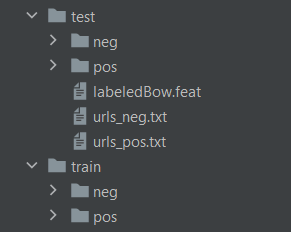

as you can see, within each folder there's a seperate folder for both positive and negative comments(in terms of sentiment towards the movie)

In [18]:
!conda activate base

In [19]:
!pip install pydot

## let's import some libraries!

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

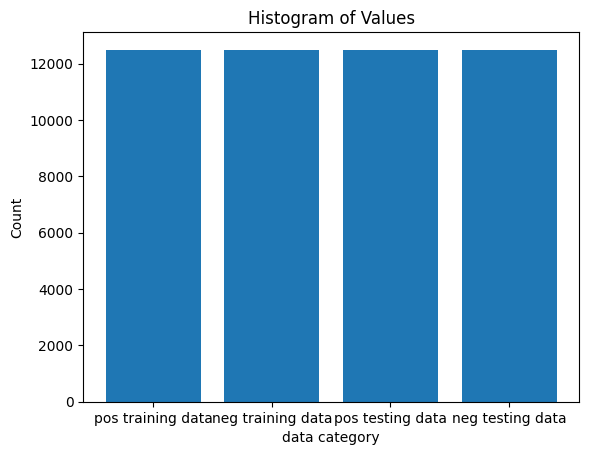

In [8]:
postrain = len(tf.io.parse_tensor(tf.io.read_file("postensor.txt"),out_type=tf.float32))
negtrain = len(tf.io.parse_tensor(tf.io.read_file("negtensor.txt"),out_type=tf.float32))
postest = len(tf.io.parse_tensor(tf.io.read_file("postensortest.txt"),out_type=tf.float32))
negtest = len(tf.io.parse_tensor(tf.io.read_file("negtensortest.txt"),out_type=tf.float32))
#print(f'{postrain} {negtrain} {postest} {negtest}')
data = {'pos training data': 12489, 'neg training data': 12495, 'pos testing data': 12493, 'neg testing data': 12492}

plt.bar(data.keys(), data.values())

plt.xlabel('data category')
plt.ylabel('Count')
plt.title('Histogram of Values')

# Show plot
plt.show()

as we can see, the testing and traing data is a 50/50 split, with about 25000 data points for each of them

## however the dataset that was given to us only contains text data and the labels were indicated by the name of the folder, we have to do some preprocessing! 

### we prepare the data in two ways:

#### 1.sentence embedding using sentenceTransformer

In [2]:
#example:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.37173440e-02 -4.28515337e-02 -1.56286322e-02  1.40537517e-02
  3.95537987e-02  1.21796295e-01  2.94333920e-02 -3.17523740e-02
  3.54959555e-02 -7.93139786e-02  1.75878610e-02 -4.04369794e-02
  4.97259460e-02  2.54912321e-02 -7.18700886e-02  8.14968944e-02
  1.47069409e-03  4.79626991e-02 -4.50336337e-02 -9.92174447e-02
 -2.81769875e-02  6.45046383e-02  4.44670767e-02 -4.76217009e-02
 -3.52952555e-02  4.38671485e-02 -5.28566204e-02  4.33042209e-04
  1.01921491e-01  1.64072458e-02  3.26996557e-02 -3.45986411e-02
  1.21339224e-02  7.94871077e-02  4.58344677e-03  1.57778151e-02
 -9.68206488e-03  2.87625454e-02 -5.05806133e-02 -1.55793708e-02
 -2.87906602e-02 -9.62281041e-03  3.15556638e-02  2.27348786e-02
  8.71449038e-02 -3.85027193e-02 -8.84718448e-02 -8.75499472e-03
 -2.12342981e-02  2.08923500e-02 -9.02077779e-02 -5.25732376e-02
 -1.05638811e-02  2.88310535e-02 -1.61454901e-02  6.17840420e-03
 -1.23234

as we can see, the sentence transformer converts text into an array for positive and negative floating point values, they are all standard scaled so applying standard scaling was not necessary

#### 2. bag of words

we have to import a set of libraries to complete this implementation:

In [10]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from pathlib import Path
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import StandardScaler
import re

first we preprocess the text by removing noise, which includes unimportant words, stemming the words!

In [11]:
def preprocess(text):
    #remove all html tags
    text = re.sub('<.*?>', '', text)
    #remove all non letters
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    #tokenization
    words = nltk.word_tokenize(text)
    #remove all stop words
    words = [w for w in words if w not in stopwords.words('english')]
    #stemming all the words e.g heard -> hear
    words = [PorterStemmer().stem(w) for w in words]
    #convert back to sentence
    text = ' '.join(words)
    return text

here is a little demonstration:

In [12]:
atext = '''
I basically skimmed through the movie but just enough to 
catch watch the plot was about. To tell you the truth it was kind 
of boring to me and at some spots it didn't make sense. 
The only reason I watched this movie in the first place was 
to see CHACE CRAWFORD!!! He is so hot, but in this movie his 
hair was kind of weird. But still hot.<br /><br />However, despite 
how hot CHACE is, it really did not make up for the film. I guess the 
plot isn't that bad but what really threw me over was the fact that they 
cuss in like every sentence. Is it that hard to express your anger without 
saying the F word every time?The cussing was annoying and the whole flashy, 
camera shaking thing gave me a headache.<br /><br />All in all, although 
the plot was OK, I found the film to be a bore and over dramatic. That's 
why I only cut to scenes with CHACE in it. LOL Anyways, not worth renting 
unless your a die-hard fan of a specific cast member like I was. 
Oh yeah the cast was Hot. The girls were HOT!!! But CHACE IS THE BEST!!
'''

In [13]:
print(preprocess(atext))

basic skim movi enough catch watch plot tell truth kind bore spot make sens reason watch movi first place see chace crawford hot movi hair kind weird still hot howev despit hot chace realli make film guess plot bad realli threw fact cuss like everi sentenc hard express anger without say f word everi time cuss annoy whole flashi camera shake thing gave headach although plot ok found film bore dramat cut scene chace lol anyway worth rent unless die hard fan specif cast member like oh yeah cast hot girl hot chace best


we then apply this to all the files in the training and testing directory, using pathlib.Path to iterate through all comments files and put them into seperate arrays, skipping the ones that, for some reason, causes unicode decode error

In [ ]:
for p in Path('../aclimdb/test/neg').glob('*.txt'):
    print("counter at " , counter1)
    print(f"{p.name}")
    file1 = open('../aclimdb/test/neg/'+p.name, "r")
    try:
        thecomment = preprocess(file1.readlines()[0])
        negdocuments.append(thecomment)
        #print(negdocuments)
        counter1 += 1
    except UnicodeDecodeError:
        print(f"Error: {p.name} cannot be decoded.")
        counter1 += 1

        file1.close()
for p in Path('../aclimdb/test/pos').glob('*.txt'):
    print("counter at " , counter1)
    print(f"{p.name}")
    file1 = open('../aclimdb/test/pos/'+p.name, "r")
    try:
        thecomment = preprocess(file1.readlines()[0])
        posdocuments.append(thecomment)
        #print(negdocuments)
        counter1 += 1
    except UnicodeDecodeError:
        print(f"Error: {p.name} cannot be decoded.")
        counter1 += 1

        file1.close()


### now we need to count the frequencies of those words!
    we do so by using the countvector class from sklearn:

In [ ]:
vectorizer = CountVectorizer(max_features=500)

vectorizer.fit(negdocuments+posdocuments)
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

we initialize the countervectorizer class by setting the max features to 500 fitting it with both positive and negative training data, which picks out the 500 most frequent words and use their count as feature values. we save the vectorizer object to file so we can use it to vectorize the training data with it. It's important to use the same vectorizer because the training data has to use the same set of features(previously we made the mistake of using two different vectorizers for training and testing data, which resulted in testing error being 15 percent higher than the resulting validation error)

In [7]:
import pickle 

with open('negdoc.pkl', 'rb') as file1:
    negdocuments = pickle.load(file1)
with open('vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

print("Vocabulary: ", vectorizer.vocabulary_)
vector = vectorizer.transform(negdocuments)
print("Encoded Document is:")
print(vector.toarray()[0:20])
#negtensor = tf.convert_to_tensor(vector.toarray(), dtype=tf.int32)

Vocabulary:  {'stori': 415, 'man': 264, 'feel': 153, 'start': 411, 'open': 306, 'scene': 371, 'exampl': 136, 'comedi': 75, 'audienc': 29, 'turn': 451, 'unfortun': 457, 'stay': 412, 'whole': 477, 'time': 439, 'gener': 172, 'make': 263, 'put': 341, 'even': 129, 'dialogu': 103, 'would': 490, 'seem': 379, 'level': 247, 'better': 42, 'might': 275, 'think': 434, 'good': 181, 'great': 183, 'star': 410, 'seen': 380, 'new': 294, 'jame': 223, 'also': 12, 'daughter': 92, 'son': 402, 'take': 426, 'robert': 363, 'two': 454, 'michael': 274, 'almost': 9, 'hit': 202, 'right': 362, 'short': 389, 'cours': 85, 'problem': 338, 'help': 196, 'run': 365, 'known': 233, 'differ': 105, 'second': 377, 'direct': 106, 'like': 250, 'say': 370, 'sort': 405, 'classic': 72, 'entertain': 124, 'although': 13, 'reason': 351, 'three': 437, 'film': 157, 'far': 149, 'actual': 6, 'one': 305, 'best': 41, 'plot': 327, 'nice': 296, 'see': 378, 'mayb': 269, 'tri': 448, 'origin': 308, 'anoth': 19, 'flick': 162, 'end': 121, 'face'

## training validation test split:

For all neural network models as well as TFDF models, we split the training data into .8 and .2 training and validation split. And since the testing data is the same size as the training data, the eventual split is 4 : 1 : 5.(training 40% validation 10% testing 50%)
For all the scikit models, we only have testing and training data(50% 50%)

## modeling and evaluation: 
we tried many different machine learning algorithms

In [11]:
from tensorflow.keras.utils import plot_model



## 1. logistic regression

we started with simpler models to create a baseline for measuring performance of more complex models:

#### bag of words:

#### Training:

we started out with max-iteration 60, however it told us it hasn't yet converge and got the resulting training and testing error
:

Training error rate: 0.14661383285302598 <br>
Validation error rate: 0.15153091855113066

#### evaluation:

testing eror rate: 0.15153091855113066


<Axes: >

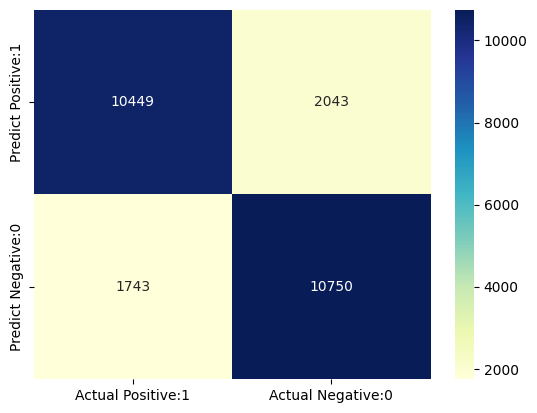

In [20]:
import joblib
new_model = joblib.load("../model/LoregScikitbow.joblib")
import tensorflow as tf
from sklearn.metrics import zero_one_loss
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
testdata = tf.io.parse_tensor(tf.io.read_file("mixedinputbowtest.txt"),out_type=tf.int32)
testlabel = tf.io.parse_tensor(tf.io.read_file("inputlabelbowtest.txt"),out_type=tf.int32)
#accidentally stored the labels as floats, but it takes too much time to reprepare the data, so we decided to just
##convert them back to integers every time we load the data
testlabel1 = [1 if a == 1 else 0 for a in testlabel]
testlabel1 = tf.convert_to_tensor(testlabel1, dtype=tf.int32)
predict1 = new_model.predict(testdata)
predict1 = [1 if a >=0.5 else 0 for a in predict1]
print("testing eror rate:",zero_one_loss(testlabel1,predict1))
cm = confusion_matrix(testlabel1,predict1 )
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                  index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## 2.decision tree

#### bag of words

### Training:

we used the decision tree implementation in sklearn: we tuned two hyperparameters min_sample_leafs and max_depth to achieve the best performance, Both of which are ways to reduce overfitting. We understood that we can achieve that through increasing min_sample_leafs or decreasing maximum depth. We also choose "entropy" as the way to measure information gain within each split 

our best model is when choosing 30 for max_depth and 30 for min_sample_leafs, which achieved <br>
Training error rate: 0.21265609990393852 <br>
Validation error rate: 0.25571342805683406

### evaluation:

testing eror rate: 0.25571342805683406


<Axes: >

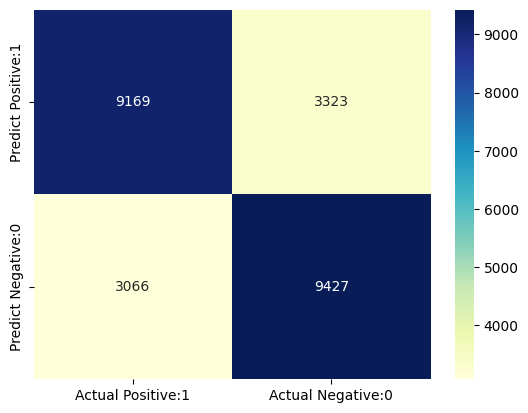

In [21]:
import joblib
new_model = joblib.load("../model/decisionTreeScikitbow.joblib")
import tensorflow as tf
from sklearn.metrics import zero_one_loss
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
testdata = tf.io.parse_tensor(tf.io.read_file("mixedinputbowtest.txt"),out_type=tf.int32)
testlabel = tf.io.parse_tensor(tf.io.read_file("inputlabelbowtest.txt"),out_type=tf.int32)
#accidentally stored the labels as floats, but it takes too much time to reprepare the data, so we decided to just
##convert them back to integers every time we load the data
testlabel1 = [1 if a == 1 else 0 for a in testlabel]
testlabel1 = tf.convert_to_tensor(testlabel1, dtype=tf.int32)
predict1 = new_model.predict(testdata)
predict1 = [1 if a >=0.5 else 0 for a in predict1]
print("testing eror rate:",zero_one_loss(testlabel1,predict1))
cm = confusion_matrix(testlabel1,predict1 )
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                  index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### 6 layer standard neural network

### training:

In [20]:
import tensorflow as tf

new_model = tf.keras.models.load_model('../model/NN_longbow')
tf.keras.utils.plot_model(
    model = new_model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


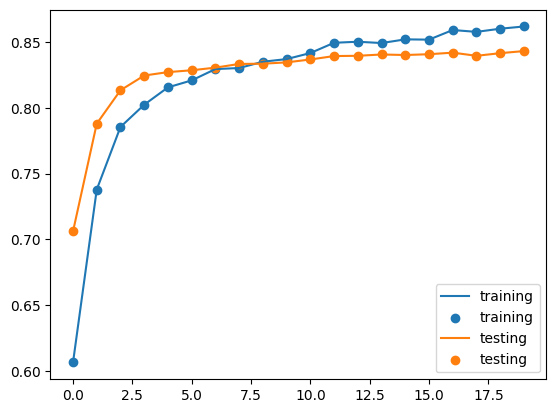

In [7]:
accuracy = [0.6063, 0.7378, 0.7854, 0.8023, 0.8155, 0.8208, 0.8294, 0.8302, 0.8350, 0.8370, 0.8416, 0.8494, 0.8502, 0.8492, 0.8520, 0.8518, 0.8591, 0.8577, 0.8601, 0.8618]
val_accuracy = [0.7060, 0.7879, 0.8133, 0.8245, 0.8271, 0.8285, 0.8305, 0.8333, 0.8335, 0.8345, 0.8367, 0.8393, 0.8395, 0.8405, 0.8401, 0.8407, 0.8419, 0.8395, 0.8415, 0.8431]
plt.plot([i for i in range(20)], accuracy,label = 'training')
plt.scatter([i for i in range(20)], accuracy,label = 'training')
plt.plot([i for i in range(20)], val_accuracy,label = 'testing')
plt.scatter([i for i in range(20)], val_accuracy,label = 'testing')
plt.legend()



In [ ]:
import tensorflow as tf
from sklearn.metrics import zero_one_loss
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
new_model = tf.keras.models.load_model('NN_longresnetwwithtworesblocksSB')
testdata = tf.io.parse_tensor(tf.io.read_file("mixedinputtest.txt"),out_type=tf.float32)
testlabel = tf.io.parse_tensor(tf.io.read_file("inputlabeltest.txt"),out_type=tf.float32)
testlabel1 = [1 if a == 1 else 0 for a in testlabel]
print(len(testlabel1))
testlabel1 = tf.convert_to_tensor(testlabel1, dtype=tf.int32)
predict1 = new_model.predict(testdata)
predict1 = [1 if a >=0.5 else 0 for a in predict1]
print(zero_one_loss(testlabel1,predict1))